# MPAS Experiments Temperarture Moisture composite

## import package

In [18]:
import sys
import numpy as np
import joblib as jl

from matplotlib import pyplot as plt

sys.path.append('/home/b11209013/Package/')
import Theory as th # type: ignore
import DataProcess as dp # type: ignore
import SignalProcess as sp # type: ignore

## Load data

In [19]:
# case name
case = 'CNTL'

# path
fname = f'/work/b11209013/2024_Research/MPAS/PC/{case}_PC.joblib'

# variable list
var_list = ['t', 'qv', 'q1']

# load principal component data
data = jl.load(fname)

lon  = data['lon']
lat  = data['lat']
time = data['time']
pc1  = data['pc1'] # dictionary for t, q1, qv pc1
pc2  = data['pc2'] # dictionary for t, q1, qv pc2

ltime, llat, llon = pc1['t'].shape

# size of the pc: (time, lat, lon)

# load EOF structure
eof = jl.load('/work/b11209013/2024_Research/MPAS/PC/CNTL_EOF.joblib')

eof1 = np.matrix(eof[:, 0]).T
eof2 = np.matrix(eof[:, 1]).T

# load LRF file
lrf = jl.load('/work/b11209013/2024_Research/MPAS/LRF/lrf_CNTL.joblib')

lev = lrf['lev']
lw  = np.where(np.isnan(lrf['lw_lrf'])==True, 0, lrf['lw_lrf'])
sw  = np.where(np.isnan(lrf['sw_lrf'])==True, 0, lrf['sw_lrf'])
cu  = np.where(np.isnan(lrf['cu_lrf'])==True, 0, lrf['cu_lrf'])


llev = len(lev)

## Reconstruct Profile

### Process PCs data

In [20]:
fmt = dp.Format(lat)

sym = {
    'pc1':{
        var: fmt.sym(pc1[var])
        for var in var_list
    },
    'pc2': {
        var: fmt.sym(pc2[var])
        for var in var_list
    }
}

### FFT on PCs

In [21]:
fft = {
    'pc1':{
        var: np.fft.fftshift(np.fft.fft2(sym['pc1'][var]))[:, ::-1]
        for var in var_list
    },
    'pc2': {
        var: np.fft.fftshift(np.fft.fft2(sym['pc2'][var]))[:, ::-1]
        for var in var_list
    }
}

### Kelvin waves bandpass filter

In [22]:
wn = np.linspace(-359, 360, 720)
fr = np.linspace(-2, 2, 376)

wnm, frm = np.meshgrid(wn, fr)

kel_curves = lambda ed, k: (86400/(2*np.pi*6.371e6))*np.sqrt(9.81*ed)*k

cond = (
    (wnm >= 1) & (wnm < 14) &
    (frm >= 1/20) & (frm <= 1/2.5) &
    (frm <= kel_curves(90, wnm)) & (frm >= kel_curves(8, wnm))
)

FFT_filtered = {
    'pc1': {
        var: np.where(cond, fft['pc1'][var]*2, 0)
        for var in var_list
    },
    'pc2': {
        var: np.where(cond, fft['pc2'][var]*2, 0)
        for var in var_list
    }
}


### IFFT on Bandpassed temperature and moisture

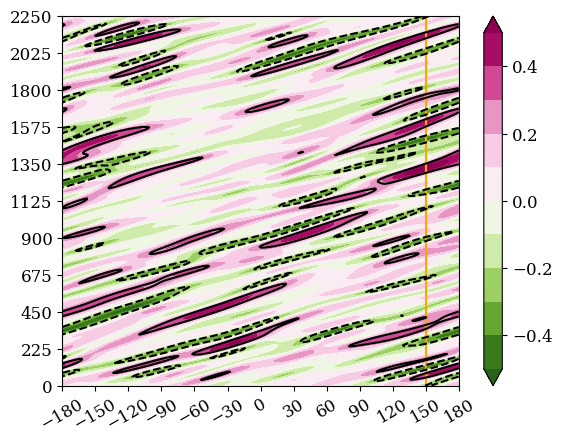

In [23]:
Recon = {
    'pc1': {
        var: np.fft.ifft2(np.fft.ifftshift(FFT_filtered['pc1'][var][:, ::-1])).real
        for var in var_list
    },
    'pc2': {
        var: np.fft.ifft2(np.fft.ifftshift(FFT_filtered['pc2'][var][:, ::-1])).real
        for var in var_list
    }
}

# shift the longitude format


c1 = plt.contourf(
    lon, time, (Recon['pc2']['t']),
    levels=np.linspace(-0.5, 0.5, 11),
    cmap='PiYG_r',
    extend='both'
    )
plt.axvline(150, color='orange')
plt.contour(
    lon, time,
    (Recon['pc2']['t']),
    levels=[-1.5*Recon['pc2']['t'].std(), 1.5*Recon['pc2']['t'].std()],
    colors='k'
)
plt.xticks(np.linspace(-180, 180, 13), rotation=30)
plt.yticks(
    np.linspace(np.min(time), np.max(time), 11),
    np.linspace(0, 2250, 11).astype(int)
)
plt.xlim(-180, 180)
plt.ylim(np.min(time), np.max(time))
plt.colorbar(c1)
plt.show()

## Select a cross-section (x-p) to test show corresponding heating profile of first/second baroclinic modes 

In [24]:
plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})

### state vector

In [25]:
lon_ref = np.argmin(np.abs(lon - 150))

t_pc1_struct = eof1.reshape((-1, 1)) @ Recon['pc1']['t'][:, lon_ref].reshape((1, -1))
t_pc2_struct = eof2.reshape((-1, 1)) @ Recon['pc2']['t'][:, lon_ref].reshape((1, -1))

q_pc1_struct = eof1.reshape((-1, 1)) @ Recon['pc1']['qv'][:, lon_ref].reshape((1, -1))
q_pc2_struct = eof2.reshape((-1, 1)) @ Recon['pc2']['qv'][:, lon_ref].reshape((1, -1))

state_pc1 = np.concatenate((t_pc1_struct, q_pc1_struct), axis=0)
state_pc2 = np.concatenate((t_pc2_struct, q_pc2_struct), axis=0)

### longwave heating

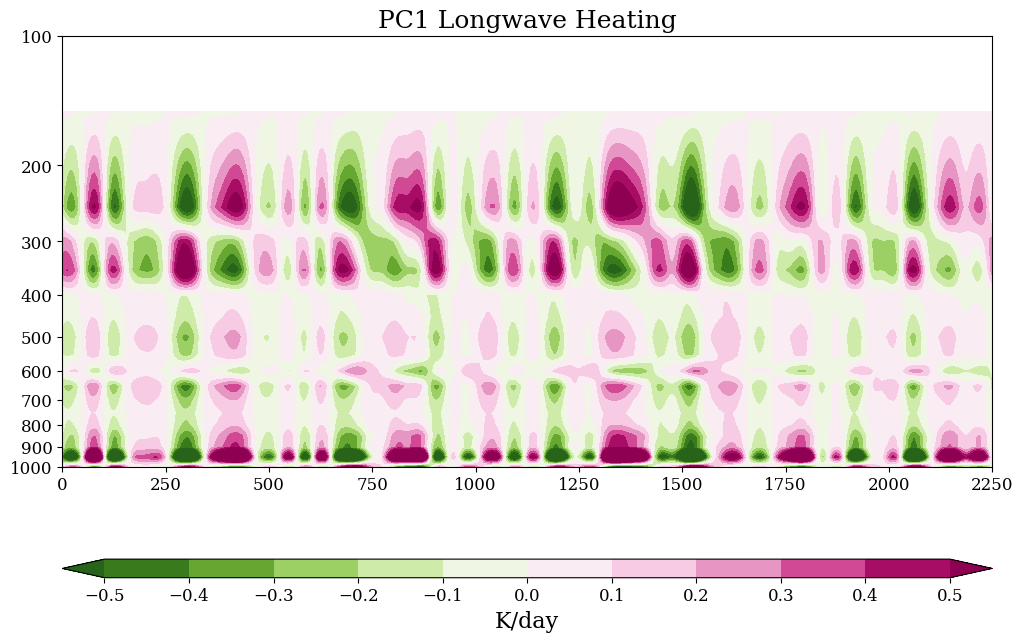

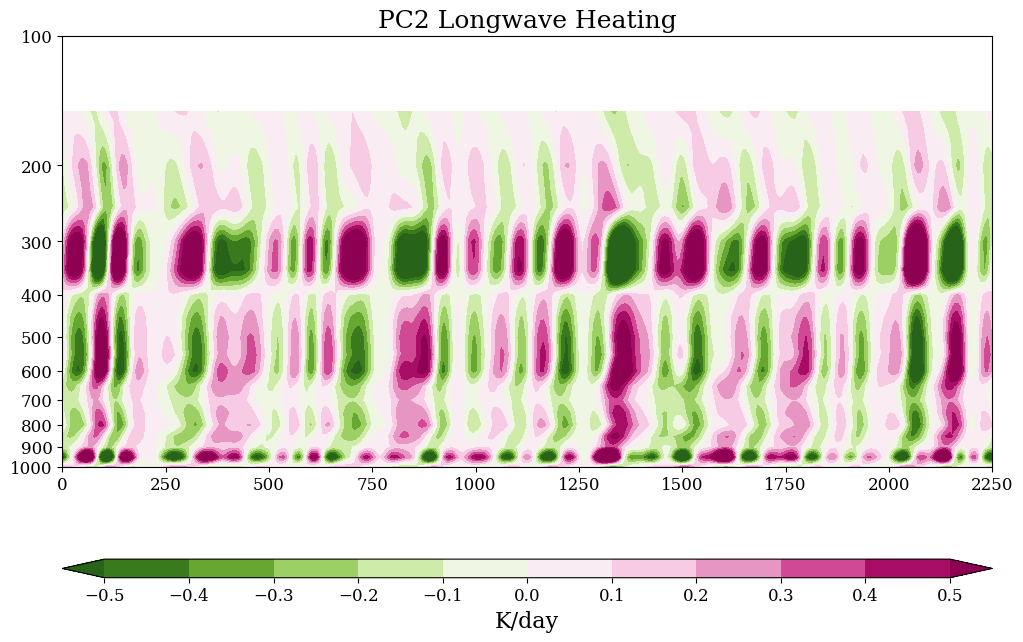

In [26]:
lw_pc1 = lw @ state_pc1
lw_pc2 = lw @ state_pc2

plt.figure(figsize=(12, 8))
plt.contourf(
    time, lev, lw_pc1,
    levels=np.linspace(-0.5, 0.5, 11),
    cmap='PiYG_r', extend='both'
    )
plt.yscale('log')
plt.xticks(np.linspace(np.min(time), np.max(time), 10), np.linspace(0, np.max(time)-np.min(time), 10).astype(int))
plt.yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10).astype(int))
plt.xlim(np.min(time), np.max(time))
plt.ylim(1000, 100)
plt.title('PC1 Longwave Heating')
cbar = plt.colorbar(orientation='horizontal', aspect=50, label='K/day')
cbar.set_ticks(np.linspace(-0.5, 0.5, 11))
plt.show()

plt.figure(figsize=(12, 8))
plt.contourf(
    time, lev, lw_pc2,
    levels=np.linspace(-0.5, 0.5, 11),
    cmap='PiYG_r', extend='both'
    )
plt.yscale('log')
plt.xticks(np.linspace(np.min(time), np.max(time), 10), np.linspace(0, np.max(time)-np.min(time), 10).astype(int))
plt.yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10).astype(int))
plt.xlim(np.min(time), np.max(time))
plt.ylim(1000, 100)
plt.title('PC2 Longwave Heating')
cbar = plt.colorbar(orientation='horizontal', aspect=50, label='K/day')
cbar.set_ticks(np.linspace(-0.5, 0.5, 11))
plt.show()

### shortwave heating

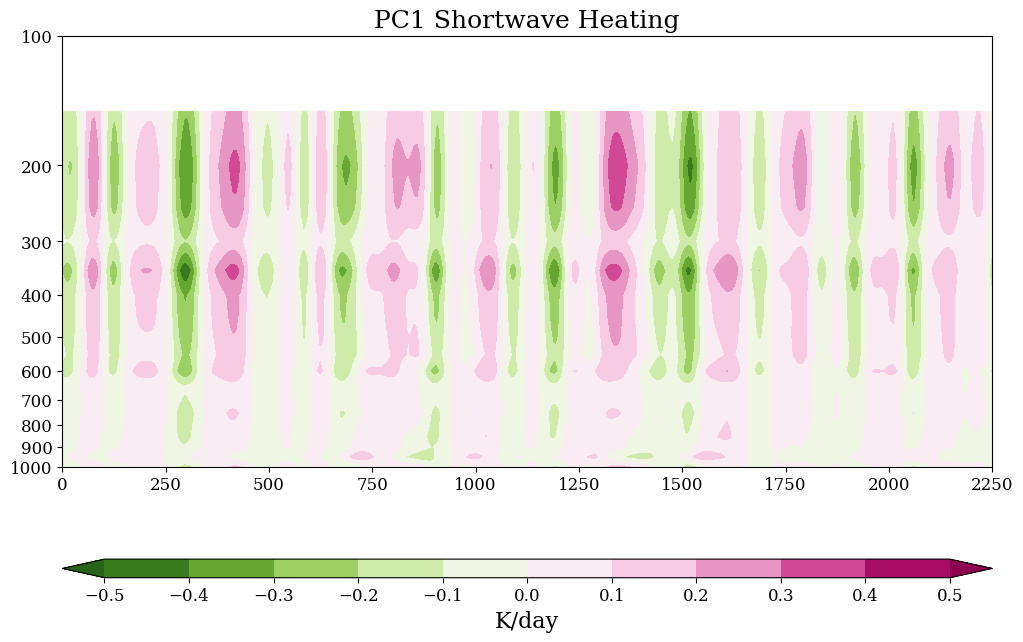

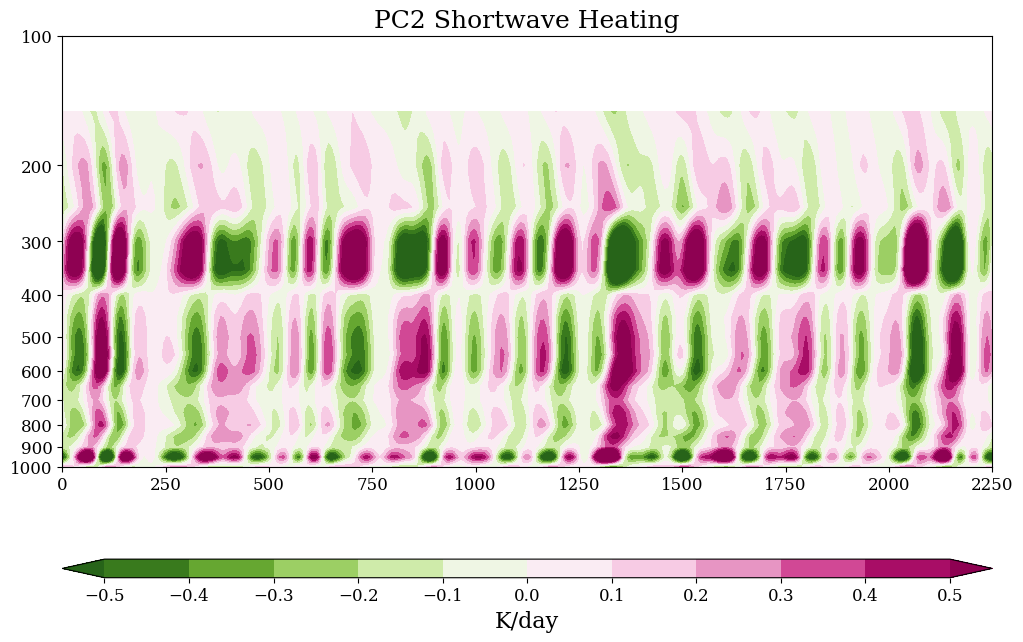

In [27]:
sw_pc1 = sw @ state_pc1
sw_pc2 = sw @ state_pc2

plt.figure(figsize=(12, 8))
plt.contourf(
    time, lev, sw_pc1,
    levels=np.linspace(-0.5, 0.5, 11),
    cmap='PiYG_r', extend='both'
    )
plt.yscale('log')
plt.xticks(np.linspace(np.min(time), np.max(time), 10), np.linspace(0, np.max(time)-np.min(time), 10).astype(int))
plt.yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10).astype(int))
plt.xlim(np.min(time), np.max(time))
plt.ylim(1000, 100)
plt.title('PC1 Shortwave Heating')
cbar = plt.colorbar(orientation='horizontal', aspect=50, label='K/day')
cbar.set_ticks(np.linspace(-0.5, 0.5, 11))
plt.show()

plt.figure(figsize=(12, 8))
plt.contourf(
    time, lev, lw_pc2,
    levels=np.linspace(-0.5, 0.5, 11),
    cmap='PiYG_r', extend='both'
    )
plt.yscale('log')
plt.xticks(np.linspace(np.min(time), np.max(time), 10), np.linspace(0, np.max(time)-np.min(time), 10).astype(int))
plt.yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10).astype(int))
plt.xlim(np.min(time), np.max(time))
plt.ylim(1000, 100)
plt.title('PC2 Shortwave Heating')
cbar = plt.colorbar(orientation='horizontal', aspect=50, label='K/day')
cbar.set_ticks(np.linspace(-0.5, 0.5, 11))
plt.show()

### cumulus heating

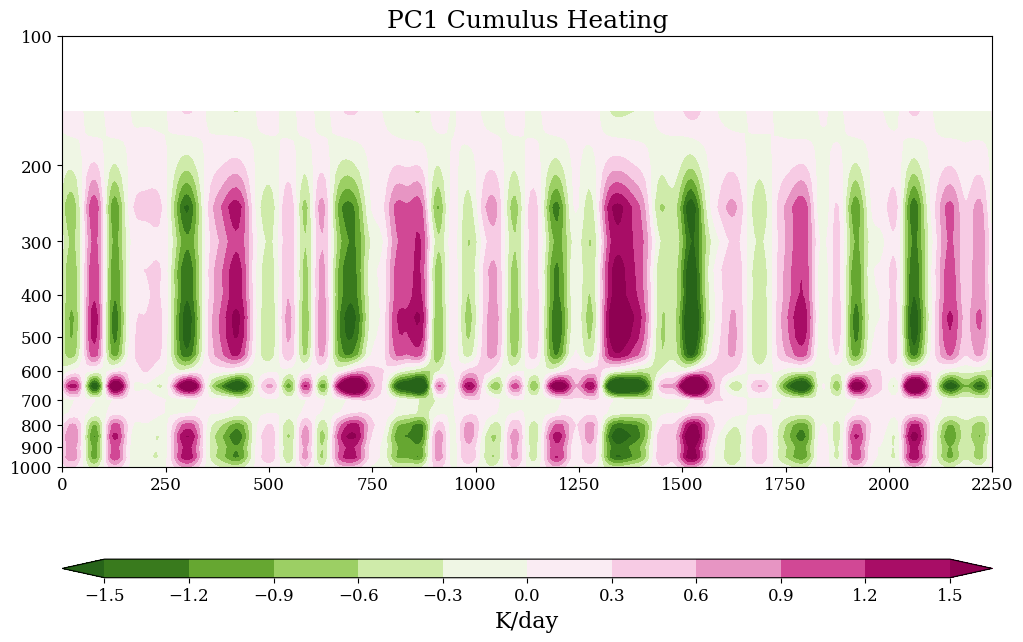

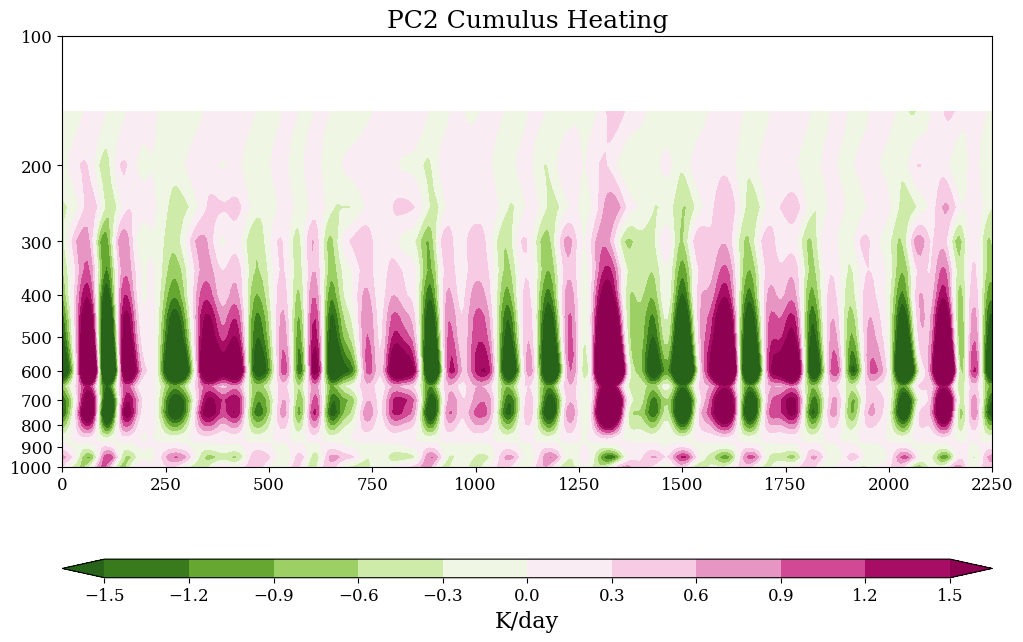

In [28]:
cu_pc1 = (cu @ state_pc1)[:18]
cu_pc2 = (cu @ state_pc2)[:18]

plt.figure(figsize=(12, 8))
plt.contourf(
    time, lev, cu_pc1,
    levels=np.linspace(-1.5, 1.5, 11),
    cmap='PiYG_r', extend='both'
    )
plt.yscale('log')
plt.xticks(np.linspace(np.min(time), np.max(time), 10), np.linspace(0, np.max(time)-np.min(time), 10).astype(int))
plt.yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10).astype(int))
plt.xlim(np.min(time), np.max(time))
plt.ylim(1000, 100)
plt.title('PC1 Cumulus Heating')
cbar = plt.colorbar(orientation='horizontal', aspect=50, label='K/day')
cbar.set_ticks(np.linspace(-1.5, 1.5, 11))
plt.show()

plt.figure(figsize=(12, 8))
plt.contourf(
    time, lev, cu_pc2,
    levels=np.linspace(-1.5, 1.5, 11),
    cmap='PiYG_r', extend='both'
    )
plt.yscale('log')
plt.xticks(np.linspace(np.min(time), np.max(time), 10), np.linspace(0, np.max(time)-np.min(time), 10).astype(int))
plt.yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10).astype(int))
plt.xlim(np.min(time), np.max(time))
plt.ylim(1000, 100)
plt.title('PC2 Cumulus Heating')
cbar = plt.colorbar(orientation='horizontal', aspect=50, label='K/day')
cbar.set_ticks(np.linspace(-1.5, 1.5, 11))
plt.show()

## Demonstrate the Q1 Cross Section


### Select Q1 time series at specific longitude


In [29]:
q1_pc1_struct = eof1.reshape((-1, 1)) @ Recon['pc1']['q1'][:, lon_ref].reshape((1, -1))
q1_pc2_struct = eof2.reshape((-1, 1)) @ Recon['pc2']['q1'][:, lon_ref].reshape((1, -1))

print(q1_pc1_struct.shape)

(18, 376)


### plot out the Q1 cross section


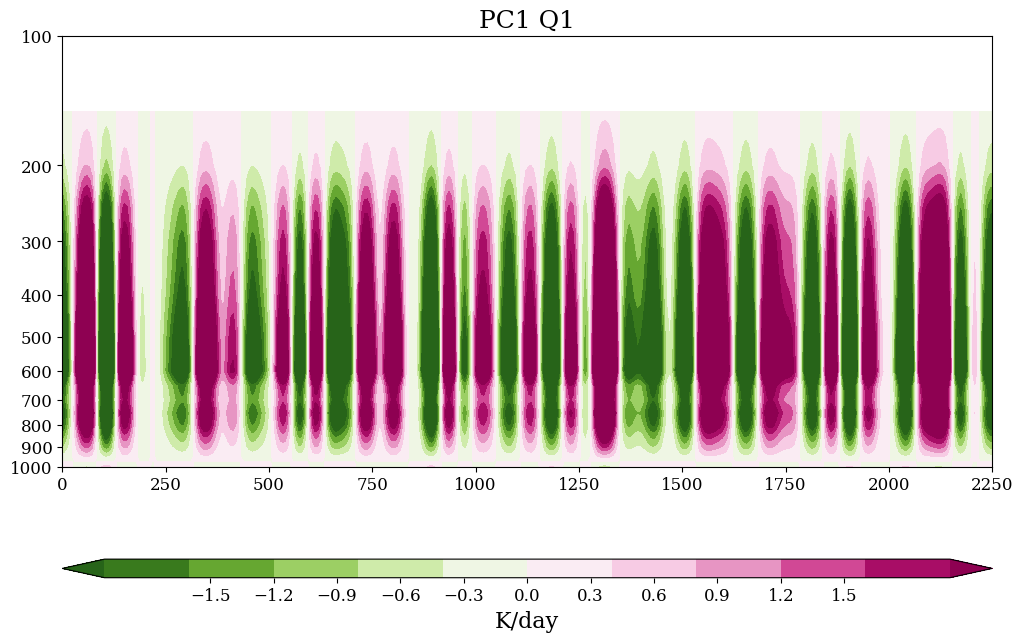

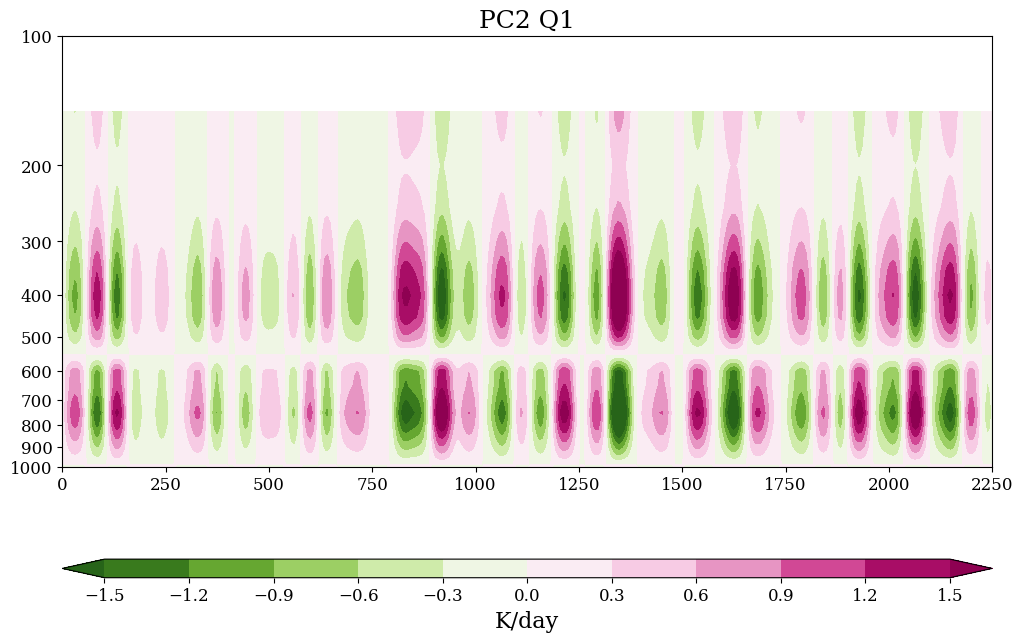

In [30]:
plt.figure(figsize=(12, 8))
plt.contourf(
    time, lev, q1_pc1_struct,
    levels=np.linspace(-2, 2, 11),
    cmap='PiYG_r', extend='both'
    )
plt.yscale('log')
plt.xticks(np.linspace(np.min(time), np.max(time), 10), np.linspace(0, np.max(time)-np.min(time), 10).astype(int))
plt.yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10).astype(int))
plt.xlim(np.min(time), np.max(time))
plt.ylim(1000, 100)
plt.title('PC1 Q1')
cbar = plt.colorbar(orientation='horizontal', aspect=50, label='K/day')
cbar.set_ticks(np.linspace(-1.5, 1.5, 11))
plt.show()

plt.figure(figsize=(12, 8))
plt.contourf(
    time, lev,q1_pc2_struct,
    levels=np.linspace(-1.5, 1.5, 11),
    cmap='PiYG_r', extend='both'
    )
plt.yscale('log')
plt.xticks(np.linspace(np.min(time), np.max(time), 10), np.linspace(0, np.max(time)-np.min(time), 10).astype(int))
plt.yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10).astype(int))
plt.xlim(np.min(time), np.max(time))
plt.ylim(1000, 100)
plt.title('PC2 Q1')
cbar = plt.colorbar(orientation='horizontal', aspect=50, label='K/day')
cbar.set_ticks(np.linspace(-1.5, 1.5, 11))
plt.show()
